In [1]:
################################################################################################################################
#
# LSTM - JANSEN - FRACDIFF - STANDARD - MONTHLY
#
################################################################################################################################

#-------------------------------------------------------------------------------------------------------------------------------
# Test RMSE: 
#-------------------------------------------------------------------------------------------------------------------------------

#===============================================================================================================================
# ENVIRONMENT: LIBRARIES, SETTINGS
#===============================================================================================================================
#pip install pandas-datareader

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import sklearn
import sklearn.preprocessing
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation
from tensorflow import keras

In [2]:
#===============================================================================================================================
# ENVIRONMENT: HARDWARE
#===============================================================================================================================
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [3]:
#===============================================================================================================================
# ENVIRONMENT: CONFIG
#===============================================================================================================================
sns.set_style('whitegrid')
np.random.seed(42)

In [4]:
#===============================================================================================================================
# DATA: PATHS - INPUT/OUTPUT
#===============================================================================================================================
input_path = Path('Data', 'Input')
results_path = Path('Data\Output', 'Jansen-LSTM-FracDiff-Standard-Monthly')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [5]:
#===============================================================================================================================
# DATA: SETTINGS
#===============================================================================================================================
seriesId='IBOV-FracDiff-Prc-Monthly'
#ESCALA = 'standard'
#EPOCAS = 100
#LOTE = 12
#NEURONS = 32
window_size=6

In [8]:
#===============================================================================================================================
# DATA: READ - FFD
#===============================================================================================================================
df = pd.read_csv('Data/Input/'+seriesId+'.csv')
#df['Date']= pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)
df

,Close
Date,
2004-07-30,5368.052427
2004-08-31,5161.160284
2004-09-30,5154.415176
2004-10-29,4563.160784
2004-11-30,6511.315022
...,...
2023-08-31,15408.101301
2023-09-29,17566.001656
2023-10-31,13856.481278


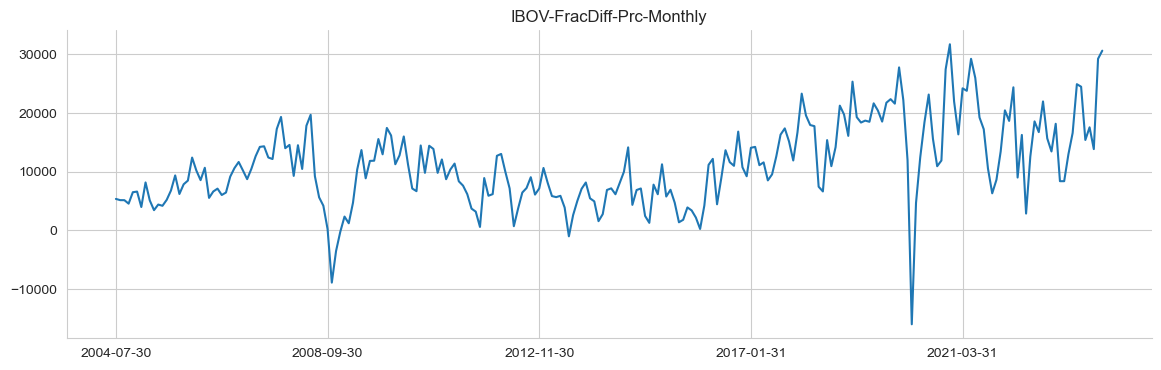

In [9]:
#===============================================================================================================================
# DATA: PLOT - FFD
#===============================================================================================================================
ax = df.plot(title=seriesId, legend=False, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [10]:
#===============================================================================================================================
# DATA: SCALE - TRAIN
#===============================================================================================================================
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = pd.Series(scaler.fit_transform(df[:'2023']).squeeze(), index=df[:'2023'].index)
df_scaled

Date
2004-07-30   -0.792311
2004-08-31   -0.822706
2004-09-30   -0.823697
2004-10-29   -0.910560
2004-11-30   -0.624351
                ...   
2022-08-31    1.148026
2022-09-30    0.879595
2022-10-31    1.647115
2022-11-30    0.723074
2022-12-29    0.395315
Length: 222, dtype: float64

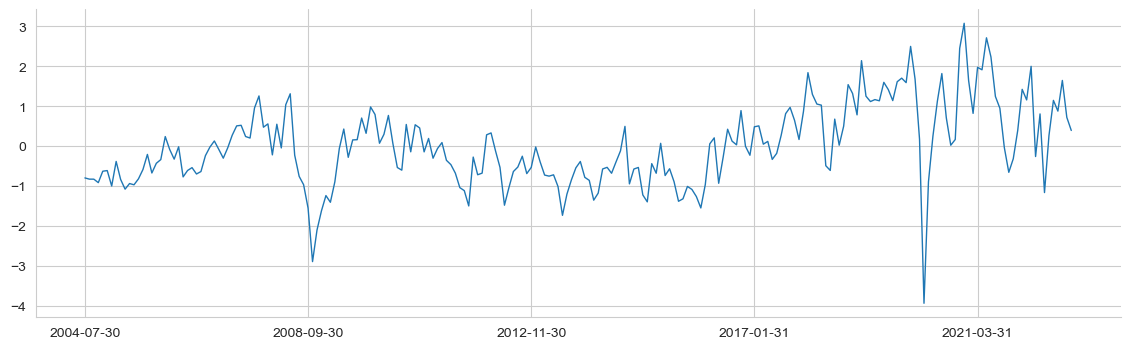

In [11]:
#===============================================================================================================================
# DATA: SCALE - PLOT - TRAIN
#===============================================================================================================================
ax = df_scaled.plot(lw=1, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [12]:
#===============================================================================================================================
# DATA: PREP - RECURRENT SEQUENCES - FUNCTION
#===============================================================================================================================
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    #y = data[window_size-1:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    #X = np.hstack(tuple([data[i: n-j+1, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

In [13]:
#===============================================================================================================================
# DATA: PREP - SEQUENCES - TRAIN
#===============================================================================================================================
X, y = create_univariate_rnn_data(df_scaled, window_size=window_size)
X

,0,1,2,3,4,5
Date,,,,,,
2005-01-31,-0.792311,-0.822706,-0.823697,-0.910560,-0.624351,-0.608634
2005-02-28,-0.822706,-0.823697,-0.910560,-0.624351,-0.608634,-0.994606
2005-03-31,-0.823697,-0.910560,-0.624351,-0.608634,-0.994606,-0.379600
2005-04-29,-0.910560,-0.624351,-0.608634,-0.994606,-0.379600,-0.829562
2005-05-31,-0.624351,-0.608634,-0.994606,-0.379600,-0.829562,-1.073421
...,...,...,...,...,...,...
2022-08-31,1.159778,2.000303,-0.256976,0.808943,-1.158842,0.267700
2022-09-30,2.000303,-0.256976,0.808943,-1.158842,0.267700,1.148026
2022-10-31,-0.256976,0.808943,-1.158842,0.267700,1.148026,0.879595


In [14]:
y

Date
2005-01-31   -0.994606
2005-02-28   -0.379600
2005-03-31   -0.829562
2005-04-29   -1.073421
2005-05-31   -0.933044
                ...   
2022-08-31    1.148026
2022-09-30    0.879595
2022-10-31    1.647115
2022-11-30    0.723074
2022-12-29    0.395315
Length: 216, dtype: float64

In [15]:
#===============================================================================================================================
# DATA PREP: SPLIT
#===============================================================================================================================
X_train = X[:'2023'].values.reshape(-1, window_size, 1)
y_train = y[:'2023']
y_train

Date
2005-01-31   -0.994606
2005-02-28   -0.379600
2005-03-31   -0.829562
2005-04-29   -1.073421
2005-05-31   -0.933044
                ...   
2022-08-31    1.148026
2022-09-30    0.879595
2022-10-31    1.647115
2022-11-30    0.723074
2022-12-29    0.395315
Length: 216, dtype: float64

In [16]:
#===============================================================================================================================
# DATA: SCALE - TEST
#===============================================================================================================================
df_scaledtest = pd.Series(scaler.transform(df['2022-07':]).squeeze(), index=df['2022-07':].index)
print(df_scaledtest.describe())
df_scaledtest

count    18.000000
mean      1.027736
std       0.931474
min      -0.348586
25%       0.410174
50%       0.869267
75%       1.522343
max       2.917503
dtype: float64


Date
2022-07-29    0.267700
2022-08-31    1.148026
2022-09-30    0.879595
2022-10-31    1.647115
2022-11-30    0.723074
2022-12-29    0.395315
2023-01-31    1.088004
2023-02-28   -0.348392
2023-03-31   -0.348586
2023-04-28    0.324748
2023-05-31    0.858938
2023-06-30    2.078790
2023-07-31    2.015902
2023-08-31    0.682702
2023-09-29    0.999726
2023-10-31    0.454749
2023-11-30    2.714332
2023-12-28    2.917503
dtype: float64

In [17]:
#===============================================================================================================================
# DATA: PREP - SEQUENCES - TEST
#===============================================================================================================================
Xtest, ytest = create_univariate_rnn_data(df_scaledtest, window_size=window_size)
Xtest

,0,1,2,3,4,5
Date,,,,,,
2023-01-31,0.267700,1.148026,0.879595,1.647115,0.723074,0.395315
2023-02-28,1.148026,0.879595,1.647115,0.723074,0.395315,1.088004
2023-03-31,0.879595,1.647115,0.723074,0.395315,1.088004,-0.348392
2023-04-28,1.647115,0.723074,0.395315,1.088004,-0.348392,-0.348586
2023-05-31,0.723074,0.395315,1.088004,-0.348392,-0.348586,0.324748
2023-06-30,0.395315,1.088004,-0.348392,-0.348586,0.324748,0.858938
2023-07-31,1.088004,-0.348392,-0.348586,0.324748,0.858938,2.078790
2023-08-31,-0.348392,-0.348586,0.324748,0.858938,2.078790,2.015902
2023-09-29,-0.348586,0.324748,0.858938,2.078790,2.015902,0.682702


In [18]:
#===============================================================================================================================
# DATA PREP: RECURRENT SEQUENCES - TEST
#===============================================================================================================================
X_test = Xtest['2023':].values.reshape(-1, window_size, 1)
y_test = ytest['2023':]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(216, 6, 1) (216,) (12, 6, 1) (12,)


In [19]:
#===============================================================================================================================
# DATA PREP: OBS, WINDOWS, FEATURES
#===============================================================================================================================
n_obs, window_size, n_features = X_train.shape
n_obs, window_size, n_features

(216, 6, 1)

In [20]:
#===============================================================================================================================
# MODEL: LSTM
#===============================================================================================================================
rnn = Sequential([
    LSTM(units=10, input_shape=(window_size, n_features), name='LSTM'),
    Dense(1, name='Output')
])

rnn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 10)                480       
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
#===============================================================================================================================
# MODEL: CONFIG
#===============================================================================================================================
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, weight_decay=0.0)

rnn.compile(loss='mean_squared_error', optimizer=optimizer)

rnn_path = (results_path / 'Jansen-FracDiff-Standard-Monthly-rnn.h5').as_posix()
checkpointer = ModelCheckpoint(filepath=rnn_path, verbose=1, monitor='val_loss', save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [22]:
#===============================================================================================================================
# MODEL: TRAIN
#===============================================================================================================================
lstm_training = rnn.fit(X_train, y_train, epochs=150, batch_size=12, shuffle=True, 
                        validation_data=(X_test, y_test), 
                        callbacks=[early_stopping, checkpointer],verbose=1)

Epoch 1/150

13/18 [====================>.........] - ETA: 0s - loss: 1.1465 
Epoch 1: val_loss improved from inf to 2.29289, saving model to Data/Output/Jansen-LSTM-FracDiff-Standard-Monthly\Jansen-FracDiff-Standard-Monthly-rnn.h5
18/18 [==============================] - 4s 58ms/step - loss: 1.0712 - val_loss: 2.2929
Epoch 2/150
13/18 [====================>.........] - ETA: 0s - loss: 0.8574
Epoch 2: val_loss improved from 2.29289 to 2.08962, saving model to Data/Output/Jansen-LSTM-FracDiff-Standard-Monthly\Jansen-FracDiff-Standard-Monthly-rnn.h5
18/18 [==============================] - 0s 8ms/step - loss: 0.9450 - val_loss: 2.0896
Epoch 3/150
13/18 [====================>.........] - ETA: 0s - loss: 0.9145
Epoch 3: val_loss improved from 2.08962 to 1.91327, saving model to Data/Output/Jansen-LSTM-FracDiff-Standard-Monthly\Jansen-FracDiff-Standard-Monthly-rnn.h5
18/18 [==============================] - 0s 8ms/step - loss: 0.8525 - val_loss: 1.9133
Epoch 4/150
13/18 [===================

Epoch 26/150
13/18 [====================>.........] - ETA: 0s - loss: 0.4649
Epoch 26: val_loss improved from 1.08621 to 1.08510, saving model to Data/Output/Jansen-LSTM-FracDiff-Standard-Monthly\Jansen-FracDiff-Standard-Monthly-rnn.h5
18/18 [==============================] - 0s 8ms/step - loss: 0.5063 - val_loss: 1.0851
Epoch 27/150
14/18 [======================>.......] - ETA: 0s - loss: 0.3939
Epoch 27: val_loss improved from 1.08510 to 1.07202, saving model to Data/Output/Jansen-LSTM-FracDiff-Standard-Monthly\Jansen-FracDiff-Standard-Monthly-rnn.h5
18/18 [==============================] - 0s 8ms/step - loss: 0.5035 - val_loss: 1.0720
Epoch 28/150
14/18 [======================>.......] - ETA: 0s - loss: 0.5276
Epoch 28: val_loss improved from 1.07202 to 1.06607, saving model to Data/Output/Jansen-LSTM-FracDiff-Standard-Monthly\Jansen-FracDiff-Standard-Monthly-rnn.h5
18/18 [==============================] - 0s 7ms/step - loss: 0.4984 - val_loss: 1.0661
Epoch 29/150
14/18 [===========

Epoch 55/150
12/18 [===================>..........] - ETA: 0s - loss: 0.2956
Epoch 55: val_loss did not improve from 0.96810
18/18 [==============================] - 0s 6ms/step - loss: 0.4438 - val_loss: 0.9744
Epoch 56/150
16/18 [=========================>....] - ETA: 0s - loss: 0.4740
Epoch 56: val_loss did not improve from 0.96810
18/18 [==============================] - 0s 6ms/step - loss: 0.4430 - val_loss: 0.9804
Epoch 57/150
17/18 [===========================>..] - ETA: 0s - loss: 0.4309
Epoch 57: val_loss did not improve from 0.96810
18/18 [==============================] - 0s 5ms/step - loss: 0.4425 - val_loss: 0.9771
Epoch 58/150
15/18 [========================>.....] - ETA: 0s - loss: 0.4367
Epoch 58: val_loss did not improve from 0.96810
18/18 [==============================] - 0s 6ms/step - loss: 0.4410 - val_loss: 0.9744
Epoch 59/150
15/18 [========================>.....] - ETA: 0s - loss: 0.4679
Epoch 59: val_loss improved from 0.96810 to 0.96328, saving model to Data/O

18/18 [==============================] - 0s 7ms/step - loss: 0.4242 - val_loss: 0.9284
Epoch 88/150
11/18 [=================>............] - ETA: 0s - loss: 0.3973
Epoch 88: val_loss did not improve from 0.91655
18/18 [==============================] - 0s 7ms/step - loss: 0.4237 - val_loss: 0.9289
Epoch 89/150
12/18 [===================>..........] - ETA: 0s - loss: 0.3879
Epoch 89: val_loss did not improve from 0.91655
18/18 [==============================] - 0s 6ms/step - loss: 0.4234 - val_loss: 0.9257
Epoch 90/150
 1/18 [>.............................] - ETA: 0s - loss: 0.4825
Epoch 90: val_loss improved from 0.91655 to 0.91578, saving model to Data/Output/Jansen-LSTM-FracDiff-Standard-Monthly\Jansen-FracDiff-Standard-Monthly-rnn.h5
18/18 [==============================] - 0s 6ms/step - loss: 0.4241 - val_loss: 0.9158
Epoch 91/150
 1/18 [>.............................] - ETA: 0s - loss: 0.3376
Epoch 91: val_loss improved from 0.91578 to 0.90476, saving model to Data/Output/Jansen-L

18/18 [==============================] - 0s 7ms/step - loss: 0.4116 - val_loss: 0.8900
Epoch 124/150
13/18 [====================>.........] - ETA: 0s - loss: 0.4325
Epoch 124: val_loss did not improve from 0.88330
18/18 [==============================] - 0s 7ms/step - loss: 0.4114 - val_loss: 0.8863
Epoch 125/150
16/18 [=========================>....] - ETA: 0s - loss: 0.4246
Epoch 125: val_loss improved from 0.88330 to 0.87434, saving model to Data/Output/Jansen-LSTM-FracDiff-Standard-Monthly\Jansen-FracDiff-Standard-Monthly-rnn.h5
18/18 [==============================] - 0s 7ms/step - loss: 0.4100 - val_loss: 0.8743
Epoch 126/150
16/18 [=========================>....] - ETA: 0s - loss: 0.3583
Epoch 126: val_loss did not improve from 0.87434
18/18 [==============================] - 0s 8ms/step - loss: 0.4110 - val_loss: 0.8793
Epoch 127/150
13/18 [====================>.........] - ETA: 0s - loss: 0.3304
Epoch 127: val_loss did not improve from 0.87434
18/18 [==========================

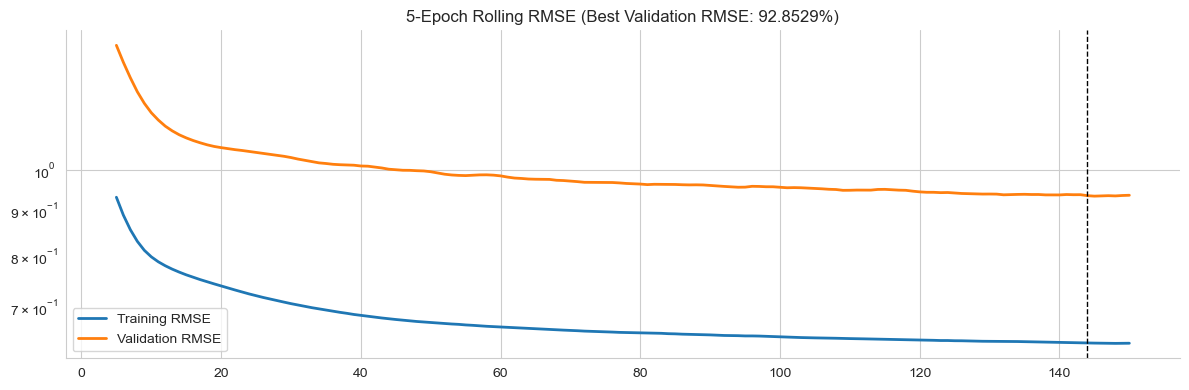

In [23]:
#===============================================================================================================================
# RESULTS: PERFORMANCE vs EPOCHS - TRAIN, VALIDATION
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_error', dpi=300);

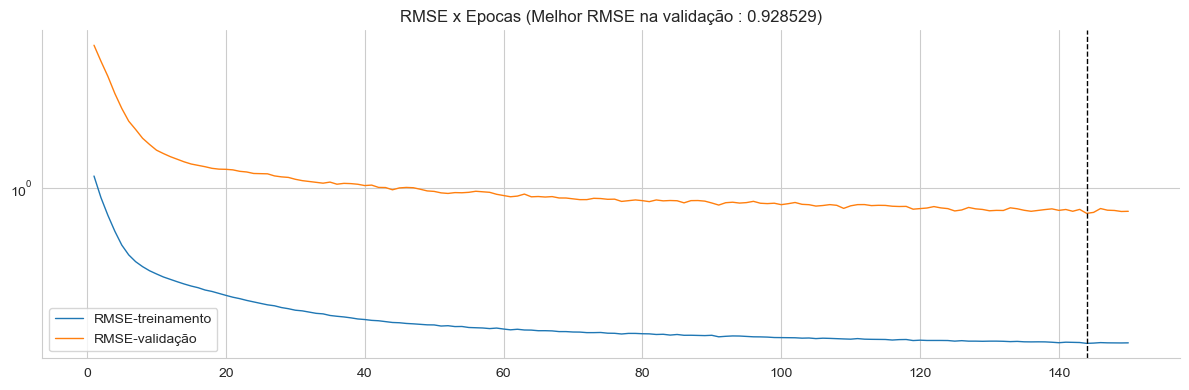

In [24]:
#===============================================================================================================================
# RESULTS - PERFORMANCE vs EPOCHS - TRAIN, VALIDATION
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'RMSE x Epocas (Melhor RMSE na validação : {best_rmse:.6})'
loss_history.columns=['RMSE-treinamento', 'RMSE-validação']
loss_history.rolling(1).mean().plot(logy=True, lw=1, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_error', dpi=300);

In [25]:
#===============================================================================================================================
# RESULTS: PERFORMANCE - TRAIN, TEST
#===============================================================================================================================
train_rmse_scaled = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')
#-------------------------------------------------------------------------------------------------------------------------------
# Train RMSE: 0.6318 | Test RMSE: 0.9447
#-------------------------------------------------------------------------------------------------------------------------------

Train RMSE: 0.6334 | Test RMSE: 0.9341


In [26]:
#===============================================================================================================================
# RESULTS: FORECAST - TRAIN, TEST
#===============================================================================================================================
train_predict_scaled = rnn.predict(X_train)
test_predict_scaled = rnn.predict(X_test)

1/1 [==============================] - 0s 34ms/step


In [27]:
#===============================================================================================================================
# RESULTS - SPEARMAN IC - TRAIN, TEST
#===============================================================================================================================
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.6f} | Test IC: {test_ic:.5f}')
#-------------------------------------------------------------------------------------------------------------------------------
# Train IC: 0.804565 | Test IC: 0.43357
#-------------------------------------------------------------------------------------------------------------------------------

Train IC: 0.804225 | Test IC: 0.44056


In [28]:
#===============================================================================================================================
# RESULTS - FORECAST - RESULTS
#===============================================================================================================================
np.savetxt('Data/Output/LSTM-Jansen-FracDiff-Standard-Monthly-Train.txt', train_predict_scaled, delimiter=';')
np.savetxt('Data/Output/LSTM-Jansen-FracDiff-Standard-Monthly-Test.txt' , test_predict_scaled , delimiter=';')
test_predict_scaled[:,0]

array([0.42281935, 1.1469761 , 0.06805953, 0.22655949, 0.66093695,
       1.0020198 , 1.6021162 , 1.2591581 , 0.42135105, 0.7990184 ,
       0.5551616 , 2.0278692 ], dtype=float32)

In [29]:
#===============================================================================================================================
# RESULTS - FRACDIFF - RECOVER - PRED - TRAIN, TEST
#===============================================================================================================================
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict  = pd.Series(scaler.inverse_transform(test_predict_scaled).squeeze() , index=y_test.index)

test_predict

Date
2023-01-31    13639.144531
2023-02-28    18568.298828
2023-03-31    11224.382812
2023-04-28    12303.252930
2023-05-31    15259.952148
2023-06-30    17581.617188
2023-07-31    21666.326172
2023-08-31    19331.894531
2023-09-29    13629.150391
2023-10-31    16199.837891
2023-11-30    14539.965820
2023-12-28    24564.320312
dtype: float32

In [30]:
#===============================================================================================================================
# RESULTS - FRACDIFF - RECOVER - TARGET - TRAIN, TEST
#===============================================================================================================================
y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

y_test_rescaled

array([18166.89173422,  8389.69761743,  8388.3809416 , 12971.59905482,
       16607.6990424 , 24910.92375634, 24482.86307971, 15408.10130136,
       17566.0016559 , 13856.48127845, 29236.8989415 , 30619.83794848])

In [31]:
#===============================================================================================================================
# RESULTS - FRACDIFF - PERFORMANCE - TRAIN, TEST
#===============================================================================================================================
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}'
#-------------------------------------------------------------------------------------------------------------------------------
# 'Train RMSE: 4300.69 | Test RMSE: 6430.60'
#-------------------------------------------------------------------------------------------------------------------------------

'Train RMSE: 4311.41 | Test RMSE: 6358.18'

In [32]:
#===============================================================================================================================
# RESULTS - FRACDIFF - STORE - TRAIN, TEST
#===============================================================================================================================
df['Train Predictions'] = train_predict
df['Test Predictions'] = test_predict

temp = pd.concat([train_predict.to_frame('predictions').assign(data='Train'), test_predict.to_frame('predictions').assign(data='Test')])
df['predictions'] = temp['predictions']
df['data']        = temp[ 'data']

df['2022-12-29':]

,Close,Train Predictions,Test Predictions,predictions,data
Date,,,,,
2022-12-29,13451.929948,14146.22168,NaN,14146.221680,Train
2023-01-31,18166.891734,NaN,13639.144531,13639.144531,Test
2023-02-28,8389.697617,NaN,18568.298828,18568.298828,Test
2023-03-31,8388.380942,NaN,11224.382812,11224.382812,Test
2023-04-28,12971.599055,NaN,12303.252930,12303.252930,Test
2023-05-31,16607.699042,NaN,15259.952148,15259.952148,Test
2023-06-30,24910.923756,NaN,17581.617188,17581.617188,Test
2023-07-31,24482.863080,NaN,21666.326172,21666.326172,Test
2023-08-31,15408.101301,NaN,19331.894531,19331.894531,Test


In [33]:
#===============================================================================================================================
# RESULTS - FRACDIFF - EXPORT
#===============================================================================================================================
df.to_excel('Data/Output/LSTM-Jansen-FracDiff-Standard-Monthly.xlsx')

KeyError: 'Residuals'

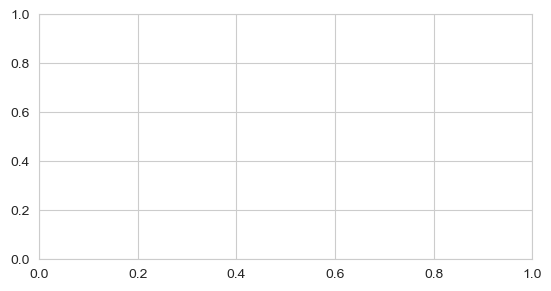

In [34]:
#===============================================================================================================================
# RESULTS - FRACDIFF - PLOT
#===============================================================================================================================
fig=plt.figure(figsize=(14,7))

ax1 = plt.subplot(221)
df.loc['2000':, 'Residuals'].plot(lw=2, ax=ax1, c='k')
df.loc['2000':, 'predictions'].plot(lw=1.5, ax=ax1, c='k')
df.loc['2000':, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')

with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x='Residuals', y='predictions', data=df, hue='data', ax=ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')
    
    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_regression', dpi=300);


In [ ]:
#===============================================================================================================================
# FRACDIFF: RECOVER - PRICES - d, THRESHOLD
#===============================================================================================================================
d=0.2485
THRESHOLD=1e-3

In [ ]:
#===============================================================================================================================
# FRACDIFF: RECOVER - FUNCTION WEIGHTS
#===============================================================================================================================
def getWeights_FFD(d, thres=THRESHOLD, lim=10000):
    w, k = [1.], 1                          # Set w as a list and k as one
    ctr = 0                                 # Set ctr
    while True:                             # Loop While
        w_ = -w[-1] / k * (d - k + 1)          # Create the new weight value
        if abs(w_) < thres:break               # End the loop in case the threshold is breached
        w.append(w_)                           # Append the new value of w
        k += 1                                 # Increment k
        ctr += 1                               # Increment ctr
        if ctr == lim - 1:break                # End the loop in case it breaches the limit
    return np.array(w[::-1]).reshape(-1, 1) # Convert the w from list to a numpy array

In [ ]:
#===============================================================================================================================
# FRACDIFF: RECOVER - WEIGHTS
#===============================================================================================================================
w_FFD = getWeights_FFD(d, thres=1e-3, lim=227)
print(len(w_FFD[:-1]))
w_FFD[:]

In [ ]:
df[-13:]

In [ ]:
#===============================================================================================================================
# PREDICTION FFD: y_pred_fracdiff
#===============================================================================================================================
#y_pred_fracdiff=df.loc['2023-01-31':,'predictions'].to_frame()
y_pred_fracdiff=df['predictions'].to_frame()
y_pred_fracdiff.rename(columns={'predictions':'Residuals'}, inplace=True)
y_pred_fracdiff[-13:]


In [ ]:
#===============================================================================================================================
# DATA: READ - PRICES - ORI
#===============================================================================================================================
seriesId = 'IBOV-monthly'
df_temp = pd.read_csv(seriesId+'.csv')

df_test_ori = df_temp.copy()
df_test_ori['Date'] = pd.to_datetime(df_test_ori['Date'], dayfirst=True)
df_test_ori = df_test_ori.loc[:, ['Date', 'Close']]
df_test_ori = df_test_ori.set_index('Date')
df_test_ori = df_test_ori['2023':]
df_test_ori

In [ ]:
#===============================================================================================================================
# DATA: RECOVER - FRACDIFF - FUNCTION
#===============================================================================================================================
def fracDiff_FFD_recover(series_ffd,d,thres=THRESHOLD, w=None,series_ori=None):

    width=len(w)
    
    df= {}
    prices_ori,df_=series_ori, pd.Series() 
    
    print('width = ',width)
    print('')
    #---------------------------------------------------------------------------------------------------------------------------
    # Loop W
    #---------------------------------------------------------------------------------------------------------------------------
    for iloc1 in range(0,width):
        print('-------------------------------------------------')
        #-----------------------------------------------------------------------------------------------------------------------
        # loc0, loc1
        #-----------------------------------------------------------------------------------------------------------------------
        loc0=prices_ori.index[iloc1]
        loc1=prices_ori.index[iloc1-width-1]
        locffd0=series_ffd.index[iloc1]

        print('')
        print('Loop: iloc1=', iloc1, ' | loc0=', loc0, ' | loc1=', loc1, ' | locffd0=', locffd0)

        if not (np.isfinite(series_ori.loc[loc1])).any():continue

        print('')
        print('w[iloc1]           = ', np.round(w[iloc1],6))
        print('series_ori[loc0]   = ', series_ori.loc[loc0,'Close'])
        print('series_ori[loc1]   = ', series_ori.loc[loc1,'Close'])
        print('series_ffd[locffd0]= ', series_ffd.loc[locffd0,'Residuals'])
            
        #-----------------------------------------------------------------------------------------------------------------------
        # Dot Product w x series_ori[loc0:loc1]
        #-----------------------------------------------------------------------------------------------------------------------
        print('')
        df_[loc1]=np.dot(w[:-1].T,series_ori.loc[loc0:loc1])[0]
        print('dot(w, series_ori  = ', df_[loc1])
        df_[loc1]=np.round(series_ffd.loc[locffd0,'Residuals'] - df_[loc1],2)
        print('Pred               = ', df_[loc1])

    df['Close']=df_.copy(deep=True)
    df=pd.concat(df,axis=1)

    return df

In [ ]:
y_pred_fracdiff.shape

In [ ]:
#===============================================================================================================================
# FRACDIFF: RECOVER - PRICES - RUN FRACDIFF RECOVER
#===============================================================================================================================
test_predict_recover_price = fracDiff_FFD_recover(y_pred_fracdiff[:], d, THRESHOLD, w_FFD[-11:], df_test_ori)

In [ ]:
#===============================================================================================================================
# PRICES: RECOVER - PRED
#===============================================================================================================================
test_predict_recover_price

In [ ]:
#===============================================================================================================================
# PRICES: READ - CLOSE
#===============================================================================================================================
dfPrices = pd.read_csv('IBOV-Monthly.csv')
dfPrices['Date'] = pd.to_datetime(dfPrices['Date'], dayfirst=True)
dfPrices.set_index('Date', inplace=True)

dfPricesTest = dfPrices.loc['2023-01-31':,'Close'].to_frame()
dfPricesTest

In [ ]:
#===============================================================================================================================
# PRICES: PERFORMANCE - PRICE
#===============================================================================================================================
#train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(dfPricesTest, test_predict_recover_price))
#print(f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')
#-------------------------------------------------------------------------------------------------------------------------------
# Test RMSE: 3822.32
#-------------------------------------------------------------------------------------------------------------------------------